In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
dfevents = pd.read_csv('../../data/ecommerce/events.csv')

In [2]:
dfcluster = pd.read_pickle('../../data/ecommerce/cust_prod_clust2.pkl', compression='zip')
dfcluster = dfcluster[dfcluster['item_count'] < 400]
# gensim_processed = dfcluster['product_list']
seriesldamask = pd.read_pickle('../../data/ecommerce/seriesldamask.pkl', compression='zip')

In [2]:
#gensim
import gensim
from gensim.utils import simple_preprocess
# from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import datetime

In [18]:
times=[]  # convert from unix time format
for i in dfevents['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
dfevents['timestamp']=times

In [6]:
dfevents.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [13]:
e_groups = dfevents.groupby('event')['itemid'].apply(list)
e_groups

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

In [5]:
dfevents['itemid'] = dfevents['itemid'].astype('str')
# dfevents['itemid'].astype('str').dtype
dfevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            object
itemid           object
transactionid    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 105.1+ MB


In [21]:
dfcluster = dfevents.groupby('visitorid')['itemid'].apply(list)
dfcluster.shape  # this takes several minutes to run. 1407580 unique users

(1407580,)

In [19]:
dfcluster.to_pickle('../../data/ecommerce/cust_prod_cluster.pkl', compression='zip')

In [27]:
SeriesList = pd.read_pickle('../../data/ecommerce/cust_prod_cluster.pkl', compression='zip')
# dfcluster.head()

In [5]:
# dfcluster = pd.DataFrame(dfcluster)
dfcluster.head()

,product_list,item_count
visitorid,,
0,"[285930, 357564, 67045]",3
2,"[216305, 325215, 342816, 325215, 342816, 25988...",8
6,"[344723, 344723, 65273, 253615, 344723, 344723]",6
7,"[164941, 139394, 226353]",3
13,"[320589, 278689]",2


In [25]:
dfcluster['item_count'] = dfcluster['itemid'].apply(len)
# dfcluster['itemid'].apply(len)[:10]

In [ ]:
dfcluster.rename(columns={"itemid": "product_list"}, inplace=True)
dfcluster.head()

In [28]:
dfcluster[dfcluster['item_count'] > 1].shape # compares to 1407580 unique users
# 406,020  users with > 1 products interacted with

(406020, 2)

In [29]:
dfcluster[dfcluster['item_count'] > 1].to_pickle('../../data/ecommerce/cust_prod_clust2.pkl', compression='zip')

In [3]:
# dfcluster = pd.read_pickle('../../data/ecommerce/cust_prod_clust2.pkl', compression='zip')
# dfcluster.head()
# dfcluster = dfcluster[dfcluster['item_count'] < 400]
print(dfcluster.shape)
# dfcluster['item_count'].sort_values(ascending=False)[50:100]

(405924, 2)


(380127, 2)


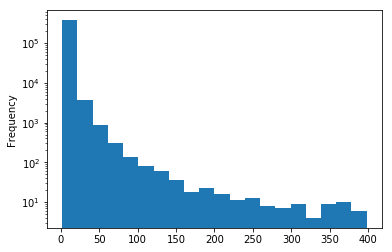

In [6]:
dfclustermask = dfcluster[seriesldamask.values]
print(dfclustermask.shape)
dfclustermask['item_count'].plot('hist', bins=20, log=True)

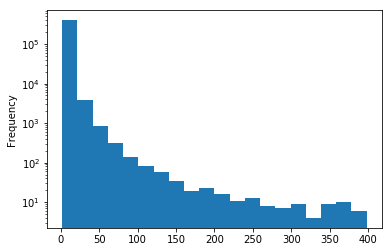

In [7]:
dfcluster['item_count'].plot('hist', bins=20, log=True)

In [91]:
gensim_processed = dfcluster['product_list']
#create dictionary
id2word = gensim.corpora.Dictionary(gensim_processed)

Filter out tokens that appear in (tokens = products)  
less than 15 documents (absolute number) or  
more than 0.5 documents (fraction of total corpus size, not absolute number).  
after the above two steps, keep only the first 100000 most frequent tokens.  

In [93]:
id2word.filter_extremes(no_below=3, no_above=0.5, keep_n=200000)

In [94]:
print(gensim_processed.shape) # number of rows
print(len(id2word)) # number of features sent to LDA model
# test LDA model in lecture notebook is (10, 62245)
# this LDA model with no filter_extremes (10, 163239)   
# tested no_above. even at 0.4 has not effect

(405924,)
69549


In [95]:
#Term Product Frequency
bow_corpus = [id2word.doc2bow(text) for text in gensim_processed]

In [96]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in bow_corpus[1:3]]

[[('216305', 2), ('259884', 1), ('325215', 3), ('342816', 2)],
 [('253615', 1), ('344723', 4), ('65273', 1)]]

class gensim.models.ldamulticore.LdaMulticore(corpus=None, num_topics=100, id2word=None, workers=None, chunksize=2000, passes=1, batch=False, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, random_state=None, minimum_probability=0.01, minimum_phi_value=0.01, per_word_topics=False, dtype=<class 'numpy.float32'>)

In [97]:
# num_topics=10  # took about 3 minutes to run original. after filters, 1 min
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=id2word, 
                                       passes=2, workers=3, random_state=9)

from gensim.test.utils import datapath  

Save model to disk.  
temp_file = datapath("model")  
lda.save(temp_file)  

Load a potentially pretrained model from disk.  
lda = LdaModel.load(temp_file)  

In [ ]:
from pprint import pprint
# Print the KeyProduct in the 10 topics
pprint(lda_model.print_topics())

In [99]:
# Compute Perplexity  # took maybe 2 minutes to run
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=gensim_processed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.531439927018745

Coherence Score:  0.6465475605570784


In [144]:
row_lda = lda_model[bow_corpus]
row_lda
print('\nPerplexity: ', round(-13.5314399, 3))  # for cat10
print('\nCoherence Score: ', round(0.64654756, 3)) # for cat10


Perplexity:  -13.531

Coherence Score:  0.647


In [100]:
lda_model.get_topics().shape  # test LDA model in lecture notebook is (10, 62245)

(10, 69549)

In [124]:
vector = lda_model[bow_corpus[5]] # idx 5 has even model output because dictionary filtered
vector = lda_model[bow_corpus[94]] # get topic probability distribution for a document
print(bow_corpus[94])
print(type(vector))
vector

[(194, 2), (195, 1), (196, 1), (197, 1), (198, 1), (199, 1), (200, 1)]
<class 'list'>


[(0, 0.23344272),
 (1, 0.011122127),
 (2, 0.122101724),
 (3, 0.12223208),
 (4, 0.12203667),
 (5, 0.011122127),
 (6, 0.011122127),
 (7, 0.34457612),
 (8, 0.011122127),
 (9, 0.011122127)]

In [138]:
# OUTPUT FROM UNSEEN USER / EXISTING USER PRODUCT INTERACTIONS
# unseen_user = [('216305', 2), ('259884', 1), ('325215', 3), ('342816', 2)]
# bow_vector = id2word.doc2bow(unseen_user)
bow_vector = [(194, 1), (195, 1), (196, 1), (197, 1), (198, 3), (199, 1), (200, 2)]
# lda_model[bow_vector]
lda_model.get_document_topics(bow_vector)
# for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
#     print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

[(0, 0.28201964),
 (2, 0.28191966),
 (3, 0.099988274),
 (4, 0.09979075),
 (7, 0.19078131)]

get_document_topics(bow, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)  
    Get the topic distribution for the given document.  
    Parameters: bow (corpus : list of (int, float)) – The document in BOW format.  
    Returns: list of (int, float) – Topic distribution for the whole document. Each element in the list is a pair of a topic’s id, and the probability that was assigned to it.  

get_topics()  
    Get the term-topic matrix learned during inference.  
    Returns  
        The probability for each word in each topic, shape (num_topics, vocabulary_size).
    Return type  
        numpy.ndarray  

https://pyldavis.readthedocs.io/en/latest/modules/API.html  
pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency, R=30, lambda_step=0.01, mds=<function js_PCoA>, n_jobs=-1, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, sort_topics=True)  
https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=  
 ---- sklearn LDA to pyLDAvis
https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb  

In [139]:
# Visualize the topics 
# running full 400K users > 23 minutes runtime
# running 69549 product LDA model: runtime = 22 minutes !!!!!
# pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)

/home/scorpio/enter/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24  
https://radimrehurek.com/gensim/models/ldamulticore.html  
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py  

In [142]:
# pyLDAvis.save_html(data, fileobj, more args**)
pyLDAvis.save_html(vis, "cat10_lda.html", template_type='general')

In [140]:
pyLDAvis.display(vis)

In [22]:
plt.style.use('seaborn-white')
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

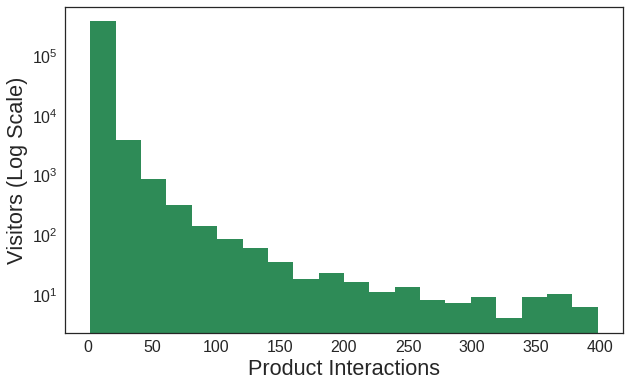

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
ax = dfclustermask['item_count'].plot('hist', bins=20, log=True, color='seagreen')
plt.xlabel('Product Interactions')
plt.ylabel('Visitors (Log Scale)')
# plt.title('Receiver operating characteristic example')
plt.savefig("../img/product_hist.png")